<a href="https://colab.research.google.com/github/khlose/homl_ageron/blob/master/homl_cp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import tarfile
from six.moves import urllib
import pandas as pd

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  
  tgz_path = os.path.join(housing_path,"housing.tgz")
  
  urllib.request.urlretrieve(housing_url,tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()
  
  
  

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path,"housing.csv")
  return pd.read_csv(csv_path)




fetch_housing_data()
housing = load_housing_data()


#housing.head()

#housing["ocean_proximity"].value_counts()
#housing.describe()

import matplotlib.pyplot as plt
#housing.hist(bins=50,figsize=(20,15))


import numpy as np
from zlib import crc32

def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test(data,test_ratio,id_column):
  
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_:test_set_check(id_,test_ratio))
  
  return data.loc[~in_test_set], data.loc[in_test_set]





#housing_with_id = housing.reset_index()
#housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
#train,test = split_train_test(housing_with_id,0.2,"index")

from sklearn.model_selection import train_test_split

train_set,test_set = train_test_split(housing,test_size=0.2,random_state=42)



housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0,inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=42)

for train_index,test_index in split.split(housing,housing["income_cat"]):
  strat_train_data = housing.loc[train_index]
  strat_test_data = housing.loc[test_index]

  
print(strat_train_data.count())  


#basically loop twice, first loop is start_train_data loop
#and second is strat_test_data loop
for set_ in (strat_train_data,strat_test_data):
  print(set_.count())
  
  set_.drop("income_cat",axis=1,inplace=True)

longitude             16512
latitude              16512
housing_median_age    16512
total_rooms           16512
total_bedrooms        16354
population            16512
households            16512
median_income         16512
median_house_value    16512
ocean_proximity       16512
income_cat            16512
dtype: int64
longitude             16512
latitude              16512
housing_median_age    16512
total_rooms           16512
total_bedrooms        16354
population            16512
households            16512
median_income         16512
median_house_value    16512
ocean_proximity       16512
income_cat            16512
dtype: int64
longitude             4128
latitude              4128
housing_median_age    4128
total_rooms           4128
total_bedrooms        4079
population            4128
households            4128
median_income         4128
median_house_value    4128
ocean_proximity       4128
income_cat            4128
dtype: int64


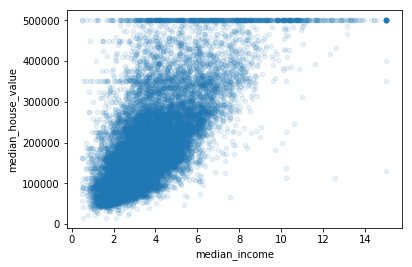

In [3]:
housing = strat_train_data.copy()

corr_matrix = housing.corr()

#corr_matrix["median_house_value"].sort_values()

from pandas.plotting import scatter_matrix

#attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]

#scatter_matrix(housing[attributes])

housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)

In [4]:
housing["room_per_household"] = housing["total_rooms"] / housing["households"]

housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

housing["populations_per_household"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values()

bedrooms_per_room           -0.259984
latitude                    -0.142724
longitude                   -0.047432
population                  -0.026920
populations_per_household   -0.021985
total_bedrooms               0.047689
households                   0.064506
housing_median_age           0.114110
total_rooms                  0.135097
room_per_household           0.146285
median_income                0.687160
median_house_value           1.000000
Name: median_house_value, dtype: float64

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

def imputeData(data):
  
  ret_data = data.copy()
  
  object_list = list(data.select_dtypes(include=['object']).columns)
  ret_data.drop(columns=object_list,axis=1,inplace=True)

  imputer = SimpleImputer(strategy="median")
  imputer.fit(ret_data)
  
  X = imputer.transform(ret_data)

  ret_data = pd.DataFrame(X,columns=ret_data.columns)
  
  #attach back the column with object
  
  wo_object =ret_data.copy()
  
  for column in object_list:
    ret_data[column] = data[column]
    
  #return dataframe without object column and a frame WITH object column
  return ret_data

from sklearn.preprocessing import OneHotEncoder

def encodeProx(data):
  
  ret_data = data.copy()
  cat_encoder = OneHotEncoder(categories='auto')
  #fill missing categorical value with just missing
  
  
  object_list = list(ret_data.select_dtypes(include=['object']).columns)
  '''for col in object_list:
    ret_data[col].fillna('Missing',inplace=True)  
    '''
  #print(pd.isnull(ret_data).sum())
  onehot = pd.get_dummies(ret_data,dummy_na=True)
  #print(ret_data["ocean_proximity"].values)
 
  return onehot

In [0]:
#transformer class

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix,bedrooms_ix,population_ix,households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  
  def __init__(self, add_bedrooms_per_room = True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
    
  def fit(self,X,y=None):
    return self
  
  def transform(self,X,y=None):
    rooms_per_household = X[:,rooms_ix] / X[:,households_ix]
    population_per_household = X[:,population_ix]/X[:,households_ix]
    if(self.add_bedrooms_per_room):
      bedrooms_per_room  = X[:,beddroms_ix] / X[:,rooms_ix]
      return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
    else:
      return np.c_[X,rooms_per_household,population_per_household]
    

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

    
    

In [0]:
#reset
housing = strat_train_data.copy()

housing_pred = strat_train_data.drop("median_house_value",axis=1)
housing_label = strat_train_data["median_house_value"].copy()



housing_tr_reg = imputeData(housing_pred)

onehotted = encodeProx(housing_tr_reg)
